## Import packages

In [2]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [5]:
aht_ds_monthly = xr.open_dataset('aht_time_series/era5_monthly_aht_time_series.nc')

### Get the temp/sphum data

In [6]:
temp_sphum_data = xr.open_dataset('era5_raw_data/monthly_surf_temps_sphum.nc').sel(time=slice('1979-01-01', '2018-12-01')).mean(['longitude']).sel(latitude=lats)

In [67]:
temp_sphum_data

<xarray.Dataset>
Dimensions:   (latitude: 361, time: 480)
Coordinates:
  * latitude  (latitude) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    q         (time, latitude) float32 0.0003332 0.0003345 ... 0.000576
    t         (time, latitude) float32 246.0 246.0 246.0 ... 267.1 267.1 267.1

In [68]:
aht_ds_monthly

<xarray.Dataset>
Dimensions:                     (time: 480, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-31 ... 2018-12-31
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

### First let's just make some scatters

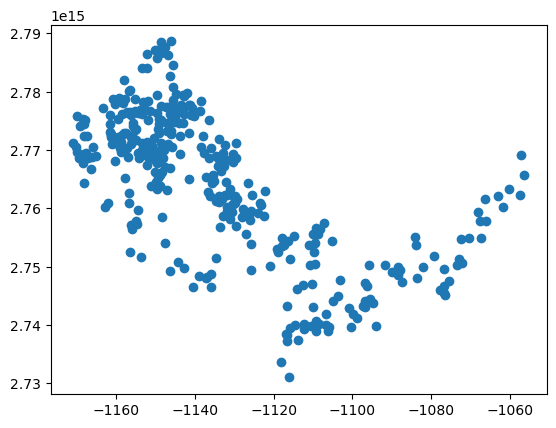

In [159]:
which_lat = 60

resample_time = '12M'

mse  = temp_sphum_data.t * cp + temp_sphum_data.q * L
mse_no_seasons = mse.groupby('time.month') - mse.groupby('time.month').mean(['time'])

mse_grad = mse.differentiate('latitude').sel(latitude=which_lat)#.resample(time=resample_time).mean(['time'])

aht = aht_ds_monthly.total_aht.sel(latitude=which_lat)#.resample(time=resample_time).mean(['time'])

#plt.scatter(mse_grad.values, aht.values)

run_ave = 120
mse_run_ave = np.convolve(mse_grad.values, np.ones(run_ave)/run_ave, mode='valid')
aht_run_ave = np.convolve(aht.values, np.ones(run_ave)/run_ave, mode='valid')

plt.scatter(mse_run_ave, aht_run_ave)

plt.show()

### Find slopes and correlations

In [170]:
slopes = np.zeros(len(lats))
r_values = np.zeros(len(lats))

#eddy_field = aht_ds.eddy_aht_no_seasons.values
#mmc_field = aht_ds.mmc_aht_no_seasons.values

mse  = temp_sphum_data.t * cp + temp_sphum_data.q * L
mse_no_seasons = mse.groupby('time.month') - mse.groupby('time.month').mean(['time'])

mse_grad = -mse.differentiate('latitude')
#mse_grad = -mse_no_seasons.differentiate('latitude')

resample_time = '24M'

run_ave = 120

aht_field = aht_ds_monthly.total_aht#.resample(time=resample_time).mean(['time'])
#mse_field = mse_grad.resample(time=resample_time).mean(['time'])


for i in range(len(lats)):
    mse_run_ave = np.convolve(mse_grad.values[:,i], np.ones(run_ave)/run_ave, mode='valid')
    aht_run_ave = np.convolve(aht_field.values[:,i], np.ones(run_ave)/run_ave, mode='valid')
    slopes[i], intercept, r_values[i], p_value, std_err = sc.linregress(mse_run_ave, aht_run_ave)



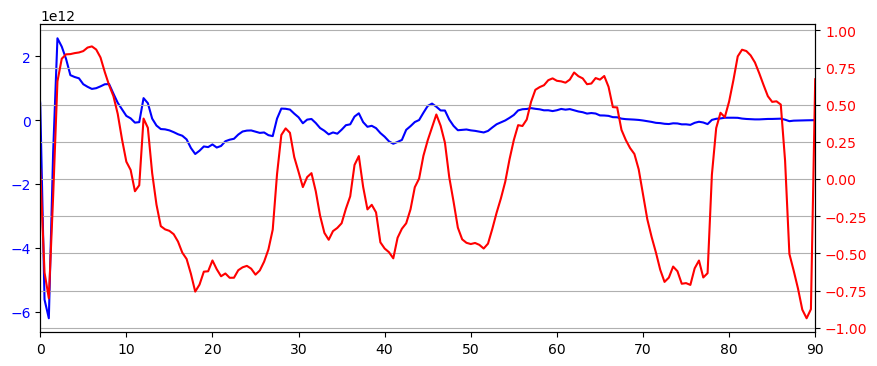

In [171]:
fig, axs = plt.subplots(1, 1, figsize=(10,4))

axs.plot(lats, slopes, color='b')
axs.set_xlim([0, 90])

axs11 = axs.twinx()


axs11.plot(lats, r_values, color='r')

axs11.set_xlim([0, 90])

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(axs, 'b')
color_y_axis(axs11, 'r')

plt.grid()
plt.show()

### Plot to show MSE gradient

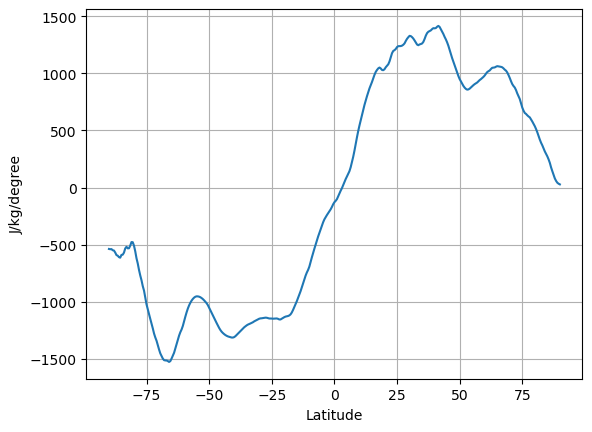

In [20]:
mse  = temp_sphum_data.t * cp + temp_sphum_data.q * L

mse_mean = mse.mean(['time'])
mse_grad = np.gradient(mse_mean, lats)

mse_grad_smoothed = np.convolve(mse_grad, np.ones(20)/20, mode='same')

plt.plot(lats, -mse_grad_smoothed)

plt.ylabel('J/kg/degree')
plt.xlabel('Latitude')

plt.grid()

#plt.savefig('figures/general_exam_plots/mse_grad_climatology')

plt.show()